# **⚠️ This is a work in progress.**

# **RL agent that mimics human-like performance in cognitive tests**

# TODO

- find appropriate behavioral datasets.
- implement Stroop environment (based on N-back).
- Some decisions to make which can be found by looking for `TODO` in the codes.
- Exploratory plots of the data.
- add more documentations.
- utility functions to plot the agent performance and the env.
- increase the number of iteration in the trainining loop.
- update slides.


# Background

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- This project aims to use behavioral data to train an agent and then use the agent to investigate data produced by human subjects. Having a computational agent that mimics humans in such tests, we will be able to compare its mechanics with human data.

- In another conception, we could fit an agent that learns many cognitive tasks that require abstract-level constructs such as executive functions. This is a multi-task control problem.

- One example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either target or non-target. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is target vs non-target. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `target`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.


## Datasets

- HCP WM task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))


Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.




### N-back

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either target or non-target. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.



## Create RL environments for cognitive tests

First install and import all the required packages:

In [ ]:
%%capture
!pip install dm-env dm-acme

import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import dm_env
import acme

from dm_env import specs

from acme import specs
from acme import wrappers


## Human dataset

We need a dataset of human perfoming a N-back test, with the following features:

- `participant_id`: following the BIDS format, it contains a unique identifier for each participant.
- `trial_index`: same as `time_step`.
- `stimulus`: same as `observation`.
- `response`: same as `action`.
- `expected_response`
- `is_correct`: same as `reward`.
- `response_time`: won't be used here.

We first produce a mock dataset with these features using the following code. Remember to replace it with real human data.

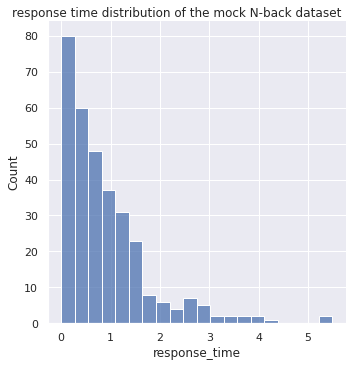

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


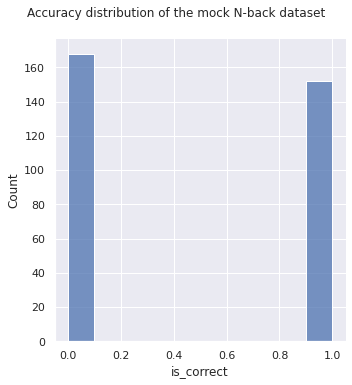

,participant_id,trial_index,stimulus,response,is_correct,response_time,expected_response
0,sub-1,1,A,non-target,True,0.560164,non-target
1,sub-1,2,A,target,True,0.239629,non-target
2,sub-1,3,E,non-target,False,0.834674,non-target
3,sub-1,4,B,target,False,0.873682,non-target
4,sub-1,5,C,target,False,1.368703,non-target
...,...,...,...,...,...,...,...
315,sub-9,28,F,target,True,0.270722,non-target
316,sub-9,29,F,target,True,0.060171,target
317,sub-9,30,E,target,True,1.027080,non-target
318,sub-9,31,A,target,False,0.595671,non-target


In [ ]:
def generate_mock_nback_dataset(N=2,
                                n_participants=10,
                                n_trials=32,
                                stimulus_choices=list('ABCDEF'),
                                response_choices=['target', 'non-target']):
  """Generate a mock dataset for the N-back task.
  
  Args:
    TODO

  Returns:
    TODO
  """

  n_rows = n_participants * n_trials

  participant_ids = sorted([f'sub-{pid}' for pid in range(1,n_participants+1)] * n_trials)
  trial_indices = list(range(1,n_trials+1)) * n_participants
  stimulus_sequence = np.random.choice(stimulus_choices, n_rows)

  responses = np.random.choice(response_choices, n_rows)
  is_corrects = np.random.choice([True, False], n_rows)
  response_times = np.random.exponential(size=n_rows)

  df = pd.DataFrame({
      'participant_id': participant_ids,
      'trial_index': trial_indices,
      'stimulus': stimulus_sequence,
      'response': responses,
      'is_correct': is_corrects,
      #TODO: is_target
      'response_time': response_times
  })

  # mark targets
  _nback_stim = df['stimulus'].shift(N)
  df['expected_response'] = (df['stimulus'] == _nback_stim).map({True: 'target', False: 'non-target'})

  return df

# ========
# now generate the actual data with the provided function and plot some of its features
mock_nback_data = generate_mock_nback_dataset()

sns.displot(data=mock_nback_data, x='response_time')
plt.suptitle('response time distribution of the mock N-back dataset', y=1.01)
plt.show()

sns.displot(data=mock_nback_data, x='is_correct')
plt.suptitle('Accuracy distribution of the mock N-back dataset', y=1.06)
plt.show()

mock_nback_data

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It receives human N-back data (or mock data if you prefer), and returns what participants performed as the observation. 

In [ ]:
class NBack(dm_env.Environment):

  ACTIONS = ['target', 'non-target']

  def __init__(self,
               N=2,
               episode_steps=32,
               stimuli_choices=list('ABCDEF'),
               human_data=None,
               seed=1,
               ):
    """TODO

    Args:
      TODO
    Returns:
      TODO

    """
    self.N = N
    self.episode_steps = episode_steps
    self.stimuli_choices = stimuli_choices
    self.stimuli = np.empty(shape=episode_steps)  # will be filled in the `reset()`

    self._reset_next_step = True

    # whether mimic humans or reward the agent once it responds optimally.
    if human_data is None:
      self._imitate_human = False
      self.human_data = None
      self.human_subject_data = None
    else:
      self._imitate_human = True
      self.human_data = human_data
      self.human_subject_data = None

    self._action_history = []

  def reset(self):
    self._reset_next_step = False
    self._current_step = 0
    self._action_history.clear()

    # generate a random sequence instead of relying on human data
    if self.human_data is None:
      self.stimuli = np.random.choice(self.stimuli_choices, self.episode_steps)
    else:
      self.human_subject_data = self.human_data.query('participant_id == participant_id.sample().iloc[0]',
                                                engine='python').sort_values('trial_index')
      self.stimuli = self.human_subject_data['stimulus'].values
      # FIXME should we always use one specific human subject or randomly select one in each episode?
      # randomly choose a subject from the human data and follow her trials and responses:

    return dm_env.restart(self._observation())


  def _episode_return(self):
    if self._imitate_human:
      return np.mean(self.human_subject_data['response'] == self._action_history)
    else:
      return 0

  def step(self, action: int):
    if self._reset_next_step:
      return self.reset()

    if self._imitate_human:
      # if it was the same action as the human subject, then reward the agent
      human_action = self.human_subject_data['response'].iloc[self._current_step]
      agent_action = NBack.ACTIONS[action]
      step_reward = (agent_action == human_action)
    else:
      # assume the agent is rationale and doesn't want to reproduce human, reward once the response it correct
      expected_action = 'target' if (self.stimuli[self._current_step] == self.stimuli[self._current_step - self.N]) else 'non-target'
      agent_action = NBack.ACTIONS[action]
      step_reward = 1. if (agent_action == expected_action) else -1.

    self._action_history.append(agent_action)

    self._current_step += 1
    
    # Check for termination.
    if self._current_step == self.stimuli.shape[0]:
      self._reset_next_step = True
      # we are using the mean of total time step rewards as the episode return
      return dm_env.termination(reward=self._episode_return(),
                                observation=self._observation())
    else:
      return dm_env.transition(reward=step_reward,
                               observation=self._observation())

  def observation_spec(self):
    return dm_env.specs.BoundedArray(
        shape=self.stimuli.shape,
        dtype=self.stimuli.dtype,
        name='nback_stimuli', minimum=0, maximum=1)

  def action_spec(self):
    return dm_env.specs.DiscreteArray(
        dtype=int,
        num_values=len(NBack.ACTIONS),
        name='action')

  def _observation(self):

    # agents observe only the current stimulus
    obs = self.stimuli[self._current_step - 1]

    # TODO uncomment to observe all the previrous stimuli instead of only the current stimulus
    # obs = self.stimuli[:self.current_step]
    # obs = ''.join(obs)

    return obs 

  def plot_state(self):
    from IPython.display import HTML
    stimuli = self.stimuli[:self._current_step - 1]
    actions = ['T' if a=='target' else '.' for a in self._action_history[:self._current_step - 1]]
    return HTML(
        '<b>Environment:</b><br />'
        f'<pre><b>Stimuli:</b> {"".join(stimuli)}</pre>'
        f'<pre><b>Actions:</b> {"".join(actions)}</pre>'
    )

  @staticmethod
  def create_environment():
    """Utility to create a N-back environment and its spec."""

    # Make sure the environment outputs single-precision floats.
    environment = wrappers.SinglePrecisionWrapper(NBack())

    # Grab the spec of the environment.
    environment_spec = specs.make_environment_spec(environment)

    return environment, environment_spec


Define a random agent (see W3D2):

In [ ]:
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

Init the environment and the agent:

In [ ]:
environment, environment_spec = NBack.create_environment()
agent = RandomAgent(environment_spec)

print('actions:\n', environment_spec.actions)
print('observations:\n', environment_spec.observations)
print('rewards:\n', environment_spec.rewards)

# DEBUG
# timestep = environment.step(NBack.ACTIONS[0])  # pytype: dm_env.TimeStep
# timestep

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=1, num_values=2)
observations:
 BoundedArray(shape=(32,), dtype=dtype('float32'), name='nback_stimuli', minimum=0.0, maximum=1.0)
rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


Run the loop (see W3D2):

In [ ]:
# fittinng parameters
n_episodes = 10
n_total_steps = 0
log_loss = False
n_steps = n_episodes * 32
all_returns = []


# main loop
for episode in range(n_episodes):
  episode_steps = 0
  episode_return = 0
  episode_loss = 0

  start_time = time.time()

  timestep = environment.reset()

  # Make the first observation.
  agent.observe_first(timestep)

  # Run an episode
  while not timestep.last():
    
    # DEBUG
    # print(timestep)

    # Generate an action from the agent's policy and step the environment.
    action = agent.select_action(timestep.observation)
    timestep = environment.step(action)

    # Have the agent observe the timestep and let the agent update itself.
    agent.observe(action, next_timestep=timestep)
    agent.update()

    # Book-keeping.
    episode_steps += 1
    n_total_steps += 1
    episode_return += timestep.reward

    if log_loss:
      episode_loss += agent.last_loss

    if n_steps is not None and n_total_steps >= n_steps:
      break

  # Collect the results and combine with counts.
  steps_per_second = episode_steps / (time.time() - start_time)
  result = {
      'episode': episode,
      'episode_length': episode_steps,
      'episode_return': episode_return,
  }
  if log_loss:
    result['loss_avg'] = episode_loss/episode_steps

  all_returns.append(episode_return)

  from IPython.display import display
  display(environment.plot_state())
  # Log the given results.
  print(result)

  if n_steps is not None and n_total_steps >= n_steps:
    break

print('\n', 'All episode returns:', all_returns)

{'episode': 0, 'episode_length': 32, 'episode_return': 9.0}


{'episode': 1, 'episode_length': 32, 'episode_return': 11.0}


{'episode': 2, 'episode_length': 32, 'episode_return': -11.0}


{'episode': 3, 'episode_length': 32, 'episode_return': -9.0}


{'episode': 4, 'episode_length': 32, 'episode_return': -1.0}


{'episode': 5, 'episode_length': 32, 'episode_return': -5.0}


{'episode': 6, 'episode_length': 32, 'episode_return': 9.0}


{'episode': 7, 'episode_length': 32, 'episode_return': 3.0}


{'episode': 8, 'episode_length': 32, 'episode_return': 5.0}


{'episode': 9, 'episode_length': 32, 'episode_return': 9.0}

 All episode returns: [9.0, 11.0, -11.0, -9.0, -1.0, -5.0, 9.0, 3.0, 5.0, 9.0]


In [ ]:
# TODO use an Acme agent

# while True:
#   # Make an initial observation.
#   step = environment.reset()
#   actor.observe_first(step.observation)

#   while not step.last():
#     # Evaluate the policy and take a step in the environment.
#     action = actor.select_action(step.observation)
#     step = environment.step(action)

#     # Make an observation and update the actor.
#     actor.observe(action, next_step=step)
#     actor.update()